In [ ]:
# pip install pytorch-tabnet lightgbm xgboost torch_geometric

In [ ]:
import pandas as pd

df = pd.read_csv('Is_longterm.csv')

df.describe()

,Loan_Institution_Past6M,Overdue_Num_Past6M,Overdue_Day_Past6M,Overdue_Day_Max_Past6M,CA_Institution_Past6M,CA_Institution_Max_Past6M,CA_UseAmount_Past6M,Card_UseAmount_Past6M,Age,Gender,Target,Long_Overdue
count,11577.000000,11577.000000,11577.000000,11577.000000,11577.000000,11577.000000,11577.000000,11577.000000,11577.000000,11577.000000,11577.000000,11577.000000
mean,0.819902,0.350004,7.244796,0.918545,0.342835,0.275201,9055.128617,15093.070744,57.241341,1.337739,0.065907,0.058392
std,0.935068,1.614758,66.780263,7.439820,0.717674,0.639033,15757.943613,16220.768876,8.705401,0.472959,0.281716,0.234493
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,31.000000,1.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6593.000000,51.000000,1.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2300.000000,11555.000000,57.000000,1.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11080.000000,18468.000000,64.000000,2.000000,0.000000,0.000000
max,8.000000,42.000000,4209.000000,569.000000,7.000000,7.000000,206300.000000,458200.000000,89.000000,2.000000,3.000000,1.000000


In [ ]:
from sklearn.model_selection import train_test_split

df.drop(columns=['Target'], inplace=True)

X = df.drop(columns=["Long_Overdue"])
y = df["Long_Overdue"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(X_train.shape, X_test.shape)
print(y_train.mean(), y_test.mean())

(9261, 10) (2316, 10)
0.05841701760069107 0.05829015544041451


### 10 Baseline Models

In [ ]:
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def seed_everything(seed=42):
    import os
    import random
    import numpy as np
    import torch

    os.environ["PYTHONHASHSEED"] = str(seed)
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # cudnn deterministic
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

device = "cuda" if torch.cuda.is_available() else "cpu"

X = df.drop(columns=["Long_Overdue"])
y = df["Long_Overdue"]

X_train_np, X_val_np, y_train_np, y_val_np = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train_np = scaler.fit_transform(X_train_np.values)
X_val_np   = scaler.transform(X_val_np.values)

# 5) numpy → tensor
X_train = torch.tensor(X_train_np, dtype=torch.float32).to(device)
X_val   = torch.tensor(X_val_np,   dtype=torch.float32).to(device)
y_train = torch.tensor(y_train_np.values, dtype=torch.float32).to(device)
y_val   = torch.tensor(y_val_np.values,   dtype=torch.float32).to(device)

input_dim = X_train.shape[1]

print("train label dist:", np.bincount(y_train_np))
print("input_dim:", input_dim)

train label dist: [8720  541]
input_dim: 10


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, input_dim, hidden=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1)
        )

    def forward(self, x):
        return self.net(x).squeeze(-1)

class SimpleRNN(nn.Module):
    def __init__(self, input_dim, hidden=64):
        super().__init__()
        self.rnn = nn.RNN(input_dim, hidden, batch_first=True)
        self.fc  = nn.Linear(hidden, 1)

    def forward(self, x):
        x = x.unsqueeze(1)        # (B, 1, F)
        _, h = self.rnn(x)        # h: (1, B, H)
        return self.fc(h.squeeze(0)).squeeze(-1)

class SimpleLSTM(nn.Module):
    def __init__(self, input_dim, hidden=64):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden, batch_first=True)
        self.fc   = nn.Linear(hidden, 1)

    def forward(self, x):
        x = x.unsqueeze(1)
        _, (h, _) = self.lstm(x)
        return self.fc(h.squeeze(0)).squeeze(-1)

class CNN1D(nn.Module):
    def __init__(self, input_dim, hidden=64):
        super().__init__()
        self.conv = nn.Conv1d(1, hidden, kernel_size=3, padding=1)
        self.fc   = nn.Linear(hidden * input_dim, 1)

    def forward(self, x):
        x = x.unsqueeze(1)                            # (B, 1, F)
        h = F.relu(self.conv(x))                      # (B, C, F)
        h = h.flatten(1)                              # (B, C*F)
        return self.fc(h).squeeze(-1)

class TinyTransformer(nn.Module):
    def __init__(self, input_dim, d_model=64, n_heads=4):
        super().__init__()
        self.proj = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=1)
        self.fc = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.proj(x).unsqueeze(1)           # (B, 1, D)
        h = self.encoder(x).squeeze(1)          # (B, D)
        return self.fc(h).squeeze(-1)

In [ ]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score
)
from torch.utils.data import TensorDataset, DataLoader


def train_simple(model, X_tr, y_tr, X_va, y_va, epochs=50, lr=1e-3, batch_size=256, seed=42):
    model = model.to(device)

    with torch.no_grad():
        n_pos = y_tr.sum().item()
        n_neg = len(y_tr) - n_pos
        pos_weight = torch.tensor(n_neg / max(1.0, n_pos), device=device, dtype=torch.float32)
    crit = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    opt = torch.optim.Adam(model.parameters(), lr=lr)

    ds_tr = TensorDataset(X_tr, y_tr)
    dl_tr = DataLoader(ds_tr, batch_size=batch_size, shuffle=True)

    for ep in range(epochs):
        model.train()
        for xb, yb in dl_tr:
            opt.zero_grad()
            logits = model(xb)
            loss = crit(logits, yb)
            loss.backward()
            opt.step()

    model.eval()
    with torch.no_grad():
        logits = model(X_va)
        probs  = torch.sigmoid(logits).detach().cpu().numpy()
        preds  = (probs >= 0.5).astype(int)
        y_true = y_va.detach().cpu().numpy()

    acc  = accuracy_score(y_true, preds)
    prec = precision_score(y_true, preds, zero_division=0)
    rec  = recall_score(y_true, preds, zero_division=0)
    f1   = f1_score(y_true, preds, zero_division=0)

    try:
        auc = roc_auc_score(y_true, probs)
    except ValueError:
        auc = np.nan

    try:
        prauc = average_precision_score(y_true, probs)
    except ValueError:
        prauc = np.nan

    return {
        "ACC": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "ROC-AUC": auc,
        "PR-AUC": prauc,
    }


results = {}

models = {
    "MLP"        : MLP(input_dim),
    "RNN"        : SimpleRNN(input_dim),
    "LSTM"       : SimpleLSTM(input_dim),
    "CNN1D"      : CNN1D(input_dim),
    "Transformer": TinyTransformer(input_dim),
}

for name, model in models.items():
    print(f"=== Train {name} ===")
    metrics = train_simple(model, X_train, y_train, X_val, y_val,
                           epochs=50, lr=1e-3)
    results[name] = metrics

print("\n=== Summary (All Models) ===")
for name, m in results.items():
    print(
        f"{name:12s} | "
        f"ACC={m['ACC']:.4f} | "
        f"P={m['Precision']:.4f} | "
        f"R={m['Recall']:.4f} | "
        f"F1={m['F1']:.4f} | "
        f"ROC-AUC={m['ROC-AUC']:.4f} | "
        f"PR-AUC={m['PR-AUC']:.4f}"
    )

=== Train MLP ===
=== Train RNN ===
=== Train LSTM ===
=== Train CNN1D ===
=== Train Transformer ===

=== Summary (All Models) ===
MLP          | ACC=0.8135 | P=0.1707 | R=0.5704 | F1=0.2628 | ROC-AUC=0.7825 | PR-AUC=0.4098
RNN          | ACC=0.8407 | P=0.2000 | R=0.5778 | F1=0.2971 | ROC-AUC=0.7879 | PR-AUC=0.4294
LSTM         | ACC=0.8169 | P=0.1782 | R=0.5926 | F1=0.2740 | ROC-AUC=0.7918 | PR-AUC=0.4342
CNN1D        | ACC=0.8597 | P=0.2189 | R=0.5481 | F1=0.3129 | ROC-AUC=0.7942 | PR-AUC=0.4323
Transformer  | ACC=0.8031 | P=0.1691 | R=0.6074 | F1=0.2645 | ROC-AUC=0.7905 | PR-AUC=0.4255


In [ ]:
from pytorch_tabnet.tab_model import TabNetClassifier

tabnet = TabNetClassifier(
    n_d=8, n_a=8,
    n_steps=3,
    gamma=1.3,
    n_independent=1,
    n_shared=1,
    lambda_sparse=1e-3,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=1e-3),
    verbose=0,
)

tabnet.fit(
    X_train_np, y_train_np,
    eval_set=[(X_val_np, y_val_np)],
    max_epochs=50,
    patience=10,
    batch_size=1024,
    virtual_batch_size=128,
)

probs_tabnet = tabnet.predict_proba(X_val_np)[:, 1]
preds_tabnet = (probs_tabnet >= 0.5).astype(int)

acc  = accuracy_score(y_val_np, preds_tabnet)
f1   = f1_score(y_val_np, preds_tabnet, zero_division=0)
auc  = roc_auc_score(y_val_np, probs_tabnet)

results["TabNet"] = {
    "ACC": acc,
    "Precision": precision_score(y_val_np, preds_tabnet, zero_division=0),
    "Recall": recall_score(y_val_np, preds_tabnet, zero_division=0),
    "F1": f1,
    "ROC-AUC": auc,
    "PR-AUC": average_precision_score(y_val_np, probs_tabnet),
}


print("\n=== Summary (All Models + TabNet) ===")
for name, m in results.items():
    print(
        f"{name:12s} | "
        f"ACC={m['ACC']:.4f} | "
        f"P={m['Precision']:.4f} | "
        f"R={m['Recall']:.4f} | "
        f"F1={m['F1']:.4f} | "
        f"ROC-AUC={m['ROC-AUC']:.4f} | "
        f"PR-AUC={m['PR-AUC']:.4f}"
    )

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score
)

def eval_model(clf, X_val, y_val):
    probs = clf.predict_proba(X_val)[:, 1]
    preds = (probs >= 0.5).astype(int)

    acc  = accuracy_score(y_val, preds)
    prec = precision_score(y_val, preds, zero_division=0)
    rec  = recall_score(y_val, preds, zero_division=0)
    f1   = f1_score(y_val, preds, zero_division=0)
    auc  = roc_auc_score(y_val, probs)
    pr   = average_precision_score(y_val, probs)

    return {
        "ACC": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "ROC-AUC": auc,
        "PR-AUC": pr,
    }


from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(
    max_iter=500,
    class_weight="balanced",
    solver="liblinear"
)
logreg.fit(X_train_np, y_train_np)

results["LogReg"] = eval_model(logreg, X_val_np, y_val_np)


from sklearn.svm import SVC

svm = SVC(
    kernel="rbf",
    probability=True,
    class_weight="balanced"
)
svm.fit(X_train_np, y_train_np)

results["SVM"] = eval_model(svm, X_val_np, y_val_np)


from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    class_weight="balanced_subsample",
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_np, y_train_np)

results["RandomForest"] = eval_model(rf, X_val_np, y_val_np)


from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=31,
    objective="binary",
    class_weight="balanced",
    random_state=42,
    n_jobs=-1,
)
lgbm.fit(X_train_np, y_train_np)

results["LightGBM"] = eval_model(lgbm, X_val_np, y_val_np)


from xgboost import XGBClassifier

neg, pos = np.bincount(y_train_np)
scale_pos_weight = neg / max(pos, 1)

xgb = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1,
)
xgb.fit(X_train_np, y_train_np)

results["XGBoost"] = eval_model(xgb, X_val_np, y_val_np)

print("\n=== Final Summary (All Models) ===")
for name, m in results.items():
    print(
        f"{name:12s} | "
        f"ACC={m['ACC']:.4f} | "
        f"P={m['Precision']:.4f} | "
        f"R={m['Recall']:.4f} | "
        f"F1={m['F1']:.4f} | "
        f"ROC-AUC={m['ROC-AUC']:.4f} | "
        f"PR-AUC={m['PR-AUC']:.4f}"
    )

Stop training because you reached max_epochs = 50 with best_epoch = 48 and best_val_0_auc = 0.7179


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== Summary (All Models + TabNet) ===
MLP          | ACC=0.8135 | P=0.1707 | R=0.5704 | F1=0.2628 | ROC-AUC=0.7825 | PR-AUC=0.4098
RNN          | ACC=0.8407 | P=0.2000 | R=0.5778 | F1=0.2971 | ROC-AUC=0.7879 | PR-AUC=0.4294
LSTM         | ACC=0.8169 | P=0.1782 | R=0.5926 | F1=0.2740 | ROC-AUC=0.7918 | PR-AUC=0.4342
CNN1D        | ACC=0.8597 | P=0.2189 | R=0.5481 | F1=0.3129 | ROC-AUC=0.7942 | PR-AUC=0.4323
Transformer  | ACC=0.8031 | P=0.1691 | R=0.6074 | F1=0.2645 | ROC-AUC=0.7905 | PR-AUC=0.4255
TabNet       | ACC=0.9452 | P=0.7222 | R=0.0963 | F1=0.1699 | ROC-AUC=0.7179 | PR-AUC=0.3016
[LightGBM] [Info] Number of positive: 541, number of negative: 8720
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000380 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 768
[LightGBM] [Info] Number of data points in the train set: 9261, number of us

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



=== Final Summary (All Models) ===
MLP          | ACC=0.8135 | P=0.1707 | R=0.5704 | F1=0.2628 | ROC-AUC=0.7825 | PR-AUC=0.4098
RNN          | ACC=0.8407 | P=0.2000 | R=0.5778 | F1=0.2971 | ROC-AUC=0.7879 | PR-AUC=0.4294
LSTM         | ACC=0.8169 | P=0.1782 | R=0.5926 | F1=0.2740 | ROC-AUC=0.7918 | PR-AUC=0.4342
CNN1D        | ACC=0.8597 | P=0.2189 | R=0.5481 | F1=0.3129 | ROC-AUC=0.7942 | PR-AUC=0.4323
Transformer  | ACC=0.8031 | P=0.1691 | R=0.6074 | F1=0.2645 | ROC-AUC=0.7905 | PR-AUC=0.4255
TabNet       | ACC=0.9452 | P=0.7222 | R=0.0963 | F1=0.1699 | ROC-AUC=0.7179 | PR-AUC=0.3016
LogReg       | ACC=0.8290 | P=0.1871 | R=0.5778 | F1=0.2826 | ROC-AUC=0.7742 | PR-AUC=0.3927
SVM          | ACC=0.9413 | P=0.4615 | R=0.0444 | F1=0.0811 | ROC-AUC=0.7992 | PR-AUC=0.2717
RandomForest | ACC=0.9495 | P=0.7250 | R=0.2148 | F1=0.3314 | ROC-AUC=0.8152 | PR-AUC=0.4099
LightGBM     | ACC=0.9162 | P=0.3145 | R=0.3704 | F1=0.3401 | ROC-AUC=0.7591 | PR-AUC=0.3660
XGBoost      | ACC=0.9275 | P=0.38

### Study 1. Transformer+Tabnet Encoder + MLP+LightGBM Decoder

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import KFold
from sklearn.metrics import average_precision_score
import gc

class DualGroupStackingEncoder(nn.Module):
    def __init__(self, input_dim, fixed_feat_idx, embed_dim=64, num_heads=8):
        super(DualGroupStackingEncoder, self).__init__()
        self.embed_dim = embed_dim
        self.register_buffer('fixed_feat_idx', torch.tensor(fixed_feat_idx, dtype=torch.long))
        self.projection = nn.Linear(1, embed_dim)
        self.group_type_embedding = nn.Embedding(2, embed_dim)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.group_tokens = nn.Parameter(torch.zeros(1, 2, embed_dim))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=num_heads, batch_first=True, dropout=0.1
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=3)
        self.fs_block = nn.Sequential(nn.Linear(embed_dim, 1), nn.Sigmoid())
        self.group_fc = nn.Linear(2 * embed_dim, embed_dim)

    def forward(self, x):
        batch_size, num_feats = x.shape
        device = x.device
        x_embedded = self.projection(x.unsqueeze(-1))
        group_indices = torch.ones(num_feats, dtype=torch.long, device=device)
        group_indices[self.fixed_feat_idx] = 0 

        group_info = self.group_type_embedding(group_indices).unsqueeze(0)
        x_embedded = x_embedded + group_info

        cls_t = self.cls_token.expand(batch_size, -1, -1)
        grp_t = self.group_tokens.expand(batch_size, -1, -1)
        tokens = torch.cat([cls_t, grp_t, x_embedded], dim=1)

        attended = self.transformer(tokens)

        z_cls = attended[:, 0, :]
        z_group = torch.relu(self.group_fc(attended[:, 1:3, :].reshape(batch_size, -1)))

        feat_tokens = attended[:, 3:, :]
        importances = self.fs_block(feat_tokens)
        masked_feat = (feat_tokens * importances).mean(dim=1)

        attn_stats = torch.cat([attended.mean(dim=1), attended.std(dim=1)], dim=1)

        return torch.cat([z_cls, z_group, masked_feat, attn_stats], dim=1)

def run_full_stacking_pipeline(X_train, y_train, X_test, y_test, n_folds=5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

    fixed_feat_idx = [8, 9]

    train_meta_features = np.zeros((len(X_train), 320))
    test_meta_features_list = []

    scaler = torch.amp.GradScaler('cuda')

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
        print(f"\n[Fold {fold+1}/{n_folds}] Training DL Encoder...")

        def get_data(df, idx):
            return df.iloc[idx].values if hasattr(df, 'iloc') else df[idx]

        X_tr_f = torch.tensor(get_data(X_train, train_idx), dtype=torch.float32, device=device)
        y_tr_f = torch.tensor(get_data(y_train, train_idx), dtype=torch.float32, device=device)
        X_val_f = torch.tensor(get_data(X_train, val_idx), dtype=torch.float32, device=device)

        train_loader = DataLoader(TensorDataset(X_tr_f, y_tr_f), batch_size=256, shuffle=True)
        encoder = DualGroupStackingEncoder(X_train.shape[1], fixed_feat_idx).to(device)
        decoder_mlp = nn.Sequential(nn.Linear(320, 1)).to(device)
        optimizer = optim.Adam(list(encoder.parameters()) + list(decoder_mlp.parameters()), lr=0.001)

        criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([15.0]).to(device))

        encoder.train(); decoder_mlp.train()
        for epoch in range(50):
            for b_x, b_y in train_loader:
                optimizer.zero_grad()
                with torch.amp.autocast('cuda'):
                    feats = encoder(b_x)
                    loss = criterion(decoder_mlp(feats).squeeze(), b_y)

                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

        encoder.eval()
        with torch.no_grad():
            train_meta_features[val_idx] = encoder(X_val_f).cpu().numpy()
            X_test_tensor = torch.FloatTensor(X_test.values if hasattr(X_test, 'values') else X_test).to(device)
            test_meta_features_list.append(encoder(X_test_tensor).cpu().numpy())
            del X_test_tensor

        del encoder, decoder_mlp, X_tr_f, y_tr_f, X_val_f
        torch.cuda.empty_cache()
        gc.collect()

    print("\n--- Final Meta-Stacking ---")

    def ensure_2d(data):
        if torch.is_tensor(data):
            arr = data.detach().cpu().numpy()
        elif hasattr(data, 'to_numpy'):
            arr = data.to_numpy()
        else:
            arr = np.array(data)

        if arr.ndim == 1:
            arr = arr.reshape(-1, 1)
        return arr

    X_tr_arr = ensure_2d(X_train)
    X_te_arr = ensure_2d(X_test)
    y_tr_arr = ensure_2d(y_train).ravel()

    test_meta_avg = np.mean(test_meta_features_list, axis=0)

    X_train_stack = np.hstack([X_tr_arr, train_meta_features])
    X_test_stack = np.hstack([X_te_arr, test_meta_avg])

    from xgboost import XGBClassifier
    xgb = XGBClassifier(
        objective="binary:logistic",
        eval_metric="aucpr",
        learning_rate=0.05,
        max_depth=6,
        scale_pos_weight=5.0,
        random_state=42,
        tree_method="hist",
        device="cuda" if torch.cuda.is_available() else "cpu"
    )

    xgb.fit(X_train_stack, y_tr_arr)
    y_prob = xgb.predict_proba(X_test_stack)[:, 1]

    print(f"Final PR-AUC: {average_precision_score(y_test, y_prob):.4f}")
    return y_prob, train_meta_features, test_meta_features_list

y_prob_final, oof_train, oof_test = run_full_stacking_pipeline(X_train, y_train, X_test, y_test)


[Fold 1/5] Training DL Encoder...


/tmp/ipython-input-3244964141.py:143: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tr_f = torch.tensor(get_data(X_train, train_idx), dtype=torch.float32, device=device)
/tmp/ipython-input-3244964141.py:144: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tr_f = torch.tensor(get_data(y_train, train_idx), dtype=torch.float32, device=device)
/tmp/ipython-input-3244964141.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val_f = torch.tensor(get_data(X_train, val_idx), dtype=torch.float32, device=device)



[Fold 2/5] Training DL Encoder...

[Fold 3/5] Training DL Encoder...

[Fold 4/5] Training DL Encoder...

[Fold 5/5] Training DL Encoder...

--- Final Meta-Stacking ---
🚀 Final PR-AUC: 0.2978


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:774: UserWarning: [03:06:52] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)



[Study 1 종합 성능 평가]
 Accuracy  Precision   Recall  F1-Score  ROC-AUC   PR-AUC
 0.945596   0.544554 0.407407  0.466102 0.687598 0.297773

[최적 임계값 기준 상세 리포트]
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      2181
           1       0.54      0.41      0.47       135

    accuracy                           0.95      2316
   macro avg       0.75      0.69      0.72      2316
weighted avg       0.94      0.95      0.94      2316



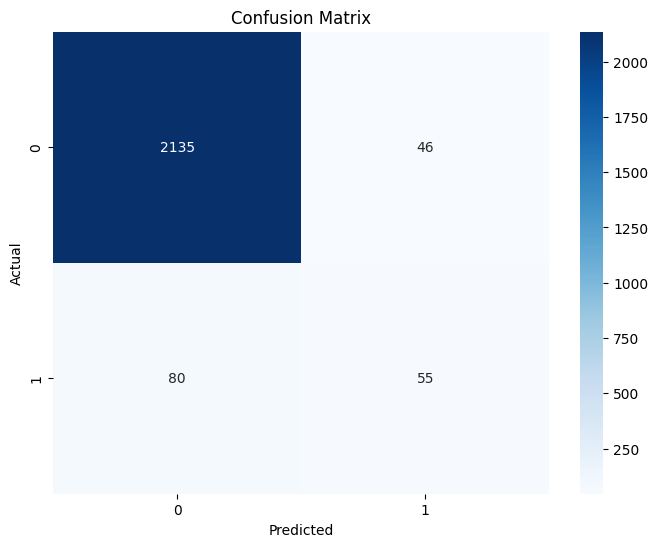

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def evaluate_performance(y_true, y_prob, model_name="EasyEnsemble"):
    from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                                 f1_score, roc_auc_score, average_precision_score,
                                 classification_report)

    y_pred = (y_prob >= 0.5).astype(int)

    metrics = {
        'Accuracy': [accuracy_score(y_true, y_pred)],
        'Precision': [precision_score(y_true, y_pred)],
        'Recall': [recall_score(y_true, y_pred)],
        'F1-Score': [f1_score(y_true, y_pred)],
        'ROC-AUC': [roc_auc_score(y_true, y_prob)],
        'PR-AUC': [average_precision_score(y_true, y_prob)]
    }

    print(f"\n[{model_name} 종합 성능 평가]")
    results_df = pd.DataFrame(metrics)
    print(results_df.to_string(index=False))

    print("\n[최적 임계값 기준 상세 리포트]")
    print(classification_report(y_true, y_pred))

    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    return

evaluate_performance(y_test, y_prob_final, model_name="Study 1")

### Study 2. Feature Extract

In [ ]:
import pandas as pd

df = pd.read_csv('Is_longterm.csv')

from sklearn.model_selection import train_test_split

df.drop(columns=['Target'], inplace=True)

X = df.drop(columns=["Long_Overdue"])
y = df["Long_Overdue"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,      
    random_state=42,    
    stratify=y       
)

print(X_train.shape, X_test.shape)
print(y_train.mean(), y_test.mean())

(9261, 10) (2316, 10)
0.05841701760069107 0.05829015544041451


In [ ]:
import torch
import torch.nn as nn

class FT_FeatureExtractor(nn.Module):
    def __init__(self, n_num_features=10, d_token=16, n_heads=4, n_layers=2):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(1, d_token) for _ in range(n_num_features)])
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_token))
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_token, nhead=n_heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

    def forward(self, x):
        tokens = [self.layers[i](x[:, i].unsqueeze(-1)) for i in range(len(self.layers))]
        x_tok = torch.stack(tokens, dim=1)
        batch_size = x.shape[0]
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x_combined = torch.cat([cls_tokens, x_tok], dim=1)
        z = self.transformer(x_combined)

        return z[:, 0, :]

In [ ]:
import torch
import numpy as np
from pytorch_tabnet.tab_model import TabNetClassifier

tabnet_model = TabNetClassifier()

tabnet_model.fit(
    X_train.to_numpy(),
    y_train.to_numpy(),
    max_epochs=50
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_mega_features(tabnet_model, ft_model, X_input):
    if hasattr(X_input, "values"):
        X_np = X_input.to_numpy()
    else:
        X_np = X_input

    device = next(ft_model.parameters()).device
    X_tensor = torch.tensor(X_np).float().to(device)

    tabnet_model.network.eval()
    ft_model.eval()

    with torch.no_grad():
        steps_output, steps_mask_values = tabnet_model.network.forward_masks(X_tensor)

        def to_numpy_robust(data_list):
            res = []
            for item in data_list:
                if torch.is_tensor(item):
                    arr = item.detach().cpu().numpy()
                elif isinstance(item, np.ndarray):
                    arr = item
                else:
                    try:
                        arr = np.array(item)
                    except:
                        continue

                if arr.ndim == 1:
                    arr = arr.reshape(-1, 1)
                elif arr.ndim == 0:
                    continue

                if arr.shape[0] == X_np.shape[0]:
                    res.append(arr)
            return res

        formatted_steps = to_numpy_robust(steps_output)
        formatted_masks = to_numpy_robust(steps_mask_values)

        if not formatted_steps:
            res_emb, _ = tabnet_model.network(X_tensor)
            all_step_embs = res_emb.detach().cpu().numpy()
        else:
            all_step_embs = np.concatenate(formatted_steps, axis=1)

        if not formatted_masks:
            tab_mask, _ = tabnet_model.explain(X_np)
            all_step_masks = tab_mask
            m1 = tab_mask
        else:
            all_step_masks = np.concatenate(formatted_masks, axis=1)
            m1 = formatted_masks[0]

        entropy = -np.sum(m1 * np.log(m1 + 1e-10), axis=1).reshape(-1, 1)
        ft_cls = ft_model(X_tensor).detach().cpu().numpy()
        if ft_cls.ndim == 1:
            ft_cls = ft_cls.reshape(-1, 1)

    print("--- Data Shape Report ---")
    try:
        print(f"1. X_np (원본/전처리 데이터): {X_np.shape}")
        print(f"2. ft_cls (CLS 토큰/최종 임베딩): {ft_cls.shape}")
        print(f"3. all_step_embs (단계별 임베딩): {all_step_embs.shape}")
        print(f"4. all_step_masks (어텐션/스텝 마스크): {all_step_masks.shape}")
        print(f"5. entropy (모델 확신도 점수): {entropy.shape}")
    except AttributeError:
        print(f"1. X_np: {X_np.shape()}")
        print(f"2. ft_cls: {ft_cls.shape()}")
        print(f"3. all_step_embs: {all_step_embs.shape()}")
        print(f"4. all_step_masks: {all_step_masks.shape()}")
        print(f"5. entropy: {entropy.shape()}")

    X_final = np.concatenate([
        X_np,         
        ft_cls,      
        all_step_embs,
        all_step_masks,
        entropy
    ], axis=1)

    return X_final

ft_model = FT_FeatureExtractor(n_num_features=10).to(device)
X_final_features = get_mega_features(tabnet_model, ft_model, X_train)
print(f"최종 Mega 피처셋 형태: {X_final_features.shape}")

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.34599 |  0:00:00s
epoch 1  | loss: 0.2474  |  0:00:00s
epoch 2  | loss: 0.22305 |  0:00:01s
epoch 3  | loss: 0.21576 |  0:00:01s
epoch 4  | loss: 0.20944 |  0:00:02s
epoch 5  | loss: 0.20679 |  0:00:02s
epoch 6  | loss: 0.19905 |  0:00:02s
epoch 7  | loss: 0.20263 |  0:00:03s
epoch 8  | loss: 0.198   |  0:00:03s
epoch 9  | loss: 0.1927  |  0:00:04s
epoch 10 | loss: 0.18967 |  0:00:04s
epoch 11 | loss: 0.18758 |  0:00:05s
epoch 12 | loss: 0.18622 |  0:00:05s
epoch 13 | loss: 0.18527 |  0:00:05s
epoch 14 | loss: 0.18253 |  0:00:06s
epoch 15 | loss: 0.18532 |  0:00:06s
epoch 16 | loss: 0.18092 |  0:00:07s
epoch 17 | loss: 0.17793 |  0:00:07s
epoch 18 | loss: 0.18146 |  0:00:07s
epoch 19 | loss: 0.18478 |  0:00:08s
epoch 20 | loss: 0.18609 |  0:00:08s
epoch 21 | loss: 0.18361 |  0:00:09s
epoch 22 | loss: 0.18165 |  0:00:09s
epoch 23 | loss: 0.17996 |  0:00:10s
epoch 24 | loss: 0.17643 |  0:00:10s
epoch 25 | loss: 0.17673 |  0:00:10s
epoch 26 | loss: 0.17738 |  0:00:11s
e

In [ ]:
from scipy.spatial.distance import mahalanobis
import numpy as np

def add_mahalanobis_feature(X_final_38, X_train_raw, y_train_raw, eps=1e-8):

    X0 = X_train_raw[y_train_raw == 0]
    X1 = X_train_raw[y_train_raw == 1]

    mu0 = X0.mean(axis=0)
    mu1 = X1.mean(axis=0)

    cov0 = np.cov(X0, rowvar=False)
    cov1 = np.cov(X1, rowvar=False)

    VI0 = np.linalg.pinv(cov0)
    VI1 = np.linalg.pinv(cov1)

    d0_list, d1_list = [], []

    for i in range(len(X_final_38)):
        x_raw = X_final_38[i, :10] 

        d0 = mahalanobis(x_raw, mu0, VI0)
        d1 = mahalanobis(x_raw, mu1, VI1)

        d0_list.append(d0)
        d1_list.append(d1)

    d0 = np.array(d0_list).reshape(-1, 1)
    d1 = np.array(d1_list).reshape(-1, 1)

    ratio = d1 / (d0 + eps)
    diff  = d0 - d1

    X_out = np.concatenate(
        [X_final_38, d0, d1, ratio, diff],
        axis=1
    )

    return X_out

X_final_43 = add_mahalanobis_feature(
    X_final_features,
    X_train.values if hasattr(X_train, "values") else X_train,
    y_train.values if hasattr(y_train, "values") else y_train
)

print("최종 feature shape:", X_final_43.shape)

최종 feature shape: (9261, 43)


In [ ]:
X_test_step1 = get_mega_features(tabnet_model, ft_model, X_test)
X_test_43 = add_mahalanobis_feature(X_test_step1, X_train, y_train)

print(f"학습 피처 형태: {X_final_43.shape}") # (N, 39)
print(f"테스트 피처 형태: {X_test_43.shape}") # (M, 39)

--- Data Shape Report ---
1. X_np (원본/전처리 데이터): (2316, 10)
2. ft_cls (CLS 토큰/최종 임베딩): (2316, 16)
3. all_step_embs (단계별 임베딩): (2316, 2)
4. all_step_masks (어텐션/스텝 마스크): (2316, 10)
5. entropy (모델 확신도 점수): (2316, 1)
학습 피처 형태: (9261, 43)
테스트 피처 형태: (2316, 43)
